# Practical 2 : Generative and Discriminative Models


# Shuyue Wang, Yiwen Wang

In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multinomial
from sklearn.preprocessing import OrdinalEncoder

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [2]:
ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
    
        loc1, scale1 = norm.fit(X)
        self.loc1=loc1
        self.scale1=scale1

        return loc1, scale1
       

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
     
        logdensity=norm.logpdf(X_new, loc=self.loc1, scale=self.scale1)
        ###################################################
        return logdensity
       
        
# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        uninumber=np.unique(X).size
        numzero=X[X==0].size
        numone=X[X==1].size
        prab=(numone+ALPHA)/(numzero+numone+uninumber*ALPHA)
        self.parameters=prab
        ###################################################
        # X is a vector with binary values
        return prab
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ##### YOUR CODE STARTS HERE #######################
        p=self.parameters
        logdensity=bernoulli.logpmf(X_new,p, loc = 0)

        ###################################################
        return logdensity
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STAlRTS HERE #######################
        
        N=self._num_of_categories
        uninumber=np.unique(X)
        count_num=[] 
        for i in range(0,N):
            number=np.sum(X==i)
            count_num.append(number)
        count_num=np.array(count_num)    
        Denominator=count_num.sum()
    
        para=[]
        for i in range(0,N):

            count_num1=count_num.copy()
            count_num1[i]=0

            nominator=count_num1.sum()
            parametor=1-((nominator+ALPHA)/(Denominator+ALPHA*(N-1)))
            para.append(parametor)
            
        para=np.array(para) 
        self._prob_of_categories=para
      
        return para

        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        Para=self._prob_of_categories
        N=self._num_of_categories
        uninumber=np.unique(X_new)
        logdensity1=[]
        
        for i in range(len(uninumber)):
            prab=np.log(Para[i])
            logdensity1.append(prab)
            
        logdensity=np.array(logdensity1)
       
        ###################################################
        return logdensity


**Tests:**
    
We will use the code below to test the correctness of your code.

In [3]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [4]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [5]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.04145387 -1.12846525 -1.04145387 -1.22377543 -1.12846525 -1.32913595
 -1.04145387 -1.44691898 -1.12846525 -1.32913595]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [6]:
# rewrite the function to calculate log probability

def Get_log_probability(X_new,types,parameter):
    
    if types=='b':
        p=parameter
        logdensity=bernoulli.logpmf(X_new,p, loc = 0).sum()
    
    elif types=='r':
        loc1=parameter[0]
        scale1=parameter[1]
        logdensity=norm.logpdf(X_new, loc=loc1, scale=scale1).sum()
    
    elif types=='c':
        num_cato=parameter[-1]
        N=int(num_cato)
        Para=parameter[0:N]
        uninumber=np.unique(X_new)
        logdensity=0

        for i in range(0,N):
            if i==X_new:
                prab=np.log(Para[i])
            else:
                prab=0
    
            logdensity=logdensity+prab

    return logdensity

In [7]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
      
        self.feature_types=feature_types
        
        ###################################################
        pass
       
        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        uniques = np.unique(y)
        self.uniques=uniques
        
        probDict = {}
        parameterDict={}
        piDict={}
  
        data=np.column_stack((y,X))
        data_nclass=pd.DataFrame(data) 
        N=len(data_nclass)
        
        for classes in uniques: # one class
  
            data_class=data_nclass.loc[data_nclass[0] ==classes] #chose one class
            n=len(data_class)
            pi=n/N
            piDict[classes]=pi
        
            data_class_np = data_class.to_numpy()
            
            y=data_class_np[:,0]
            X=data_class_np[:,1:]

            paradic={}
            
            feature_types=self.feature_types

            for i in range(len(feature_types)): # one feature type

                if feature_types[i]=='b':
                    param = BinFeatureParam()
                    theta=param.estimate(X[:,i])
                    paradic[i]=theta
            
                elif feature_types[i]=='r':
                    param = ContFeatureParam()
                    loc1, scale1 =param.estimate(X[:,i])
                    paradic[i]=[loc1, scale1]

                elif feature_types[i]=='c':     
                    cato=np.max(X[i])
                    param = CatFeatureParam(num_of_categories=cato)
                    theta=param.estimate(X[:,i])
                    theta1=np.append(theta,cato)
                    paradic[i]=theta1
        
            parameterDict[classes]=paradic
            
        self.parameters= parameterDict  
        self.pi= piDict  

        return parameterDict,piDict
 
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        yhat=[]
        for j in range(len(X)): # one single vector for estimate
            
            probDict = {}
        
            for classes in self.uniques: # one class

                type_b=[]
                type_r=[]
                type_c=[]
                feature_types=self.feature_types
            

                for i in range(len(feature_types)):  # one feature type
                    para=self.parameters[classes][i]

                    if feature_types[i]=='b':
                        probs = Get_log_probability(X[j][i],'b',para)
                        type_b.append(probs) 


                    elif feature_types[i]=='r':
                        probs = Get_log_probability(X[j][i],'r',para)
                        type_r. append(probs) 
             

                    elif feature_types[i]=='c':
                        probs = Get_log_probability(X[j][i],'c',para)
                        type_c. append(probs)

                pi=self.pi[classes]

                one_class=type_b+type_r+type_c
                one_class_prob=np.array(one_class) 
                prob=one_class_prob.sum()+np.log(pi)
               # prob=one_class_prob.sum()
                probDict[classes]=prob

        
            
            max_prob = max(zip(probDict.values(), probDict.keys()))
            
            yhat.append(max_prob[1])
            
     #   print(yhat)
        
        ###################################################
        return yhat
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


**Tests**

We will use the code below to check your code.

In [8]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [9]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


In [10]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.7241379310344828
[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [11]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [12]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers      nbc, lr,
def compareNBCvsLR( nbc,X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    
    N, D = X.shape
    m=N/num_splits
    
    tst_errs_nbc = []
    tst_errs_lr = []

    for i in range(0,int(num_splits)): # every step
        Ntrain = (i+1) * int(m)
        
        erro_nbc=[]
        erro_lg=[]
    
        for i in range(0,num_runs):  # repeat for many times
            shuffler = np.random.permutation(N)
            Xtrain = X[shuffler[:Ntrain]]
            ytrain = y[shuffler[:Ntrain]]
            Xtest = X[shuffler[Ntrain:]]
            ytest = y[shuffler[Ntrain:]]

            #NBC
            nbc_iris = NBC(feature_types=nbc)
            nbc_iris.fit(Xtrain, ytrain)
            yhat = nbc_iris.predict(Xtest)
            test_accuracy = np.mean(yhat == ytest)
            
            
            testerro_nbc=1-test_accuracy
            erro_nbc.append(testerro_nbc)
            
             #logistic
            clf = LogisticRegression(random_state=0).fit(Xtrain, ytrain)
            clf.predict_proba(X[:2, :])

            score=clf.score(X, y)
            testerro_lg=1-score
            erro_lg.append(testerro_lg)        
            
        average_erro_nbc=np.array(erro_nbc).mean()
        tst_errs_nbc.append(average_erro_nbc)
        
        average_erro_lg=np.array(erro_lg).mean()
        tst_errs_lr.append(average_erro_lg)
        

    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

In [13]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [14]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris = load_iris()

X, y = iris['data'], iris['target']

a,b=compareNBCvsLR(['r','r','r','r'], X, y, num_runs=200, num_splits=10)

###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

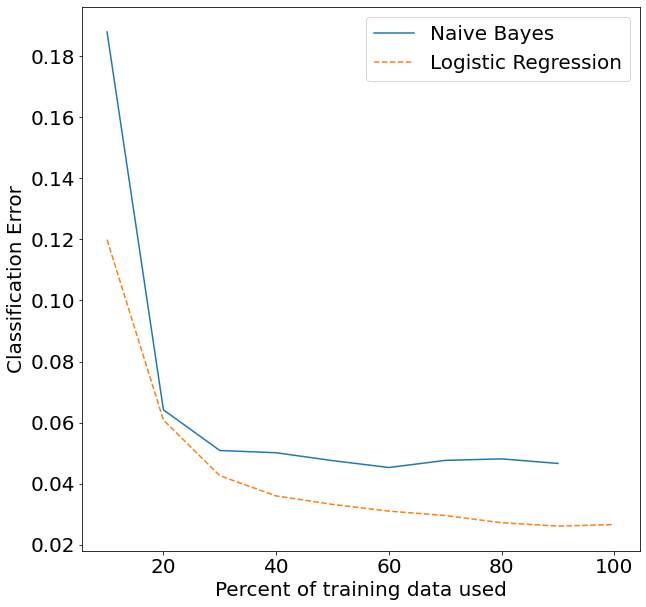

In [15]:
makePlot(a, b, title=None, num_splits=10)

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

In [35]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('./voting.csv')

voting_new=voting.dropna()
voting_new=voting_new.replace('n',0)
voting_new=voting_new.replace('y',1)

votdata = voting_new.sample(n=100, random_state=2000)

y = np.array(votdata['label'])
X= np.array(votdata.iloc[:,1:])


###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

In [36]:
a,b=compareNBCvsLR(['b'] * 16,X, y, num_runs=200, num_splits=10)

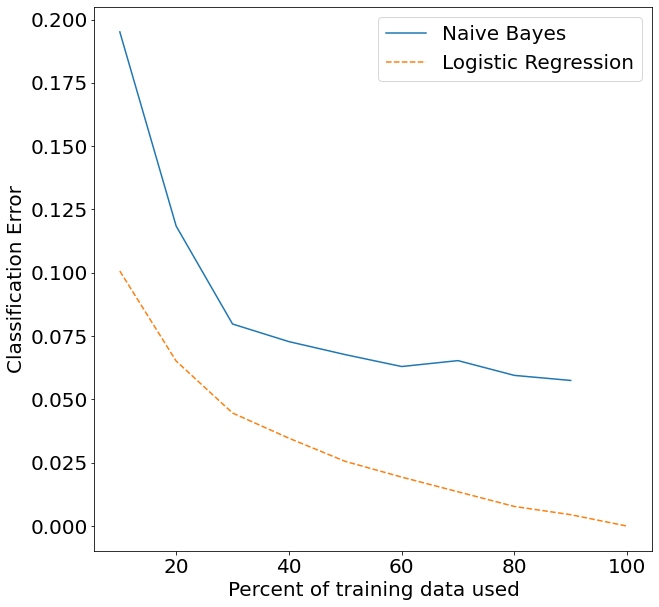

In [38]:
makePlot(a, b, title=None, num_splits=10)